In [ ]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt


sf_username = '*******'
sf_password = '*********'
sf_account = '*********'
sf_warehouse = 'COMPUTE_WH'
sf_database = 'TESTDB'
sf_schema = 'CORE'

dbcon = snowflake.connector.connect(
    user=sf_username,
    password=sf_password,
    account=sf_account,
    warehouse=sf_warehouse,
    database=sf_database,
    schema=sf_schema
)

## Question 1:
#### How many subscribers are there for each channel?

,CHANNEL_NAME,Title,Number of Subcribers
0,straitstimesonline,The Straits Times,589000
1,zaobaodotsg,zaobaosg,182000
2,TheBusinessTimes,The Business Times,26800
3,BeritaHarianSG1957,Berita Harian Singapura,5000
4,Tamil_Murasu,Tamil Murasu,4850


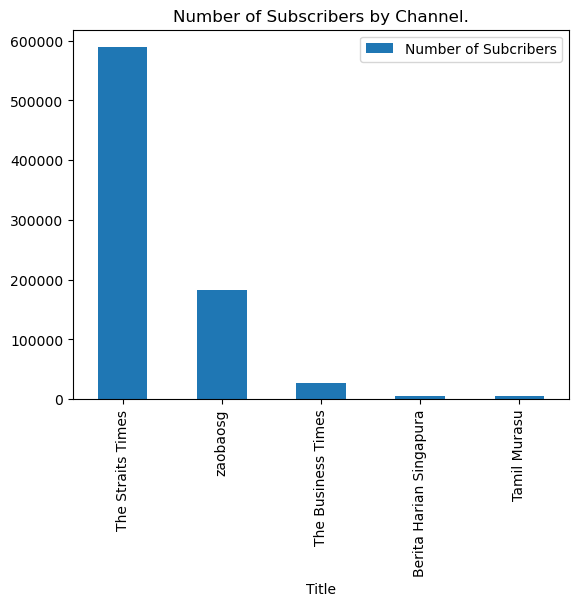

In [7]:
data = pd.read_sql("""select channel_name,title as "Title",subscriber_count as "Number of Subcribers" 
from CORE.tbl_yt_channel_md order by 3 desc;""",dbcon)
display(data)
data.plot(x='Title',y=['Number of Subcribers'],kind='bar',title='Number of Subscribers by Channel.')
#data.plot(x='AGE_GROUP',y='AVG_REVOLVING_UTIL_OF_UNSECURED_LINES',kind='bar',title='Age vs Lifestyle')
plt.show()

## Question 2:
#### How many video’s have been published for each channel?

/opt/anaconda3/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


,CHANNEL_NAME,Title,Number of Videos
0,straitstimesonline,The Straits Times,30434
1,zaobaodotsg,zaobaosg,5322
2,TheBusinessTimes,The Business Times,1269
3,BeritaHarianSG1957,Berita Harian Singapura,450
4,Tamil_Murasu,Tamil Murasu,449


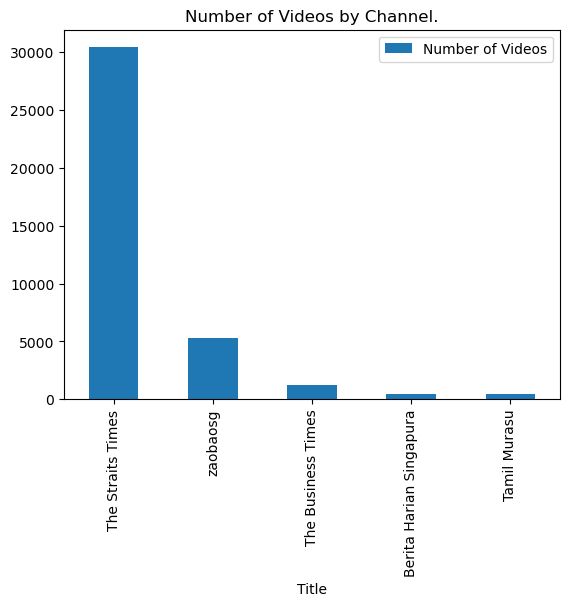

In [9]:
data = pd.read_sql("""select channel_name,title as "Title",video_count as "Number of Videos" 
from CORE.tbl_yt_channel_md order by 3 desc;""",dbcon)
display(data)
data.plot(x='Title',y=['Number of Videos'],kind='bar',title='Number of Videos by Channel.')
#data.plot(x='AGE_GROUP',y='AVG_REVOLVING_UTIL_OF_UNSECURED_LINES',kind='bar',title='Age vs Lifestyle')
plt.show()

## Question 3:
#### What is the trend for videos published by each channel over the last 12 months?

In [26]:
data = pd.read_sql("""SELECT 
    TO_CHAR(a.published_at, 'Mon') AS Month,
    TO_CHAR(a.published_at, 'MM') AS Month_num,
    chnl.title as "Channel Name",
    count(a.id) as "Number of videos"
FROM 
    CORE.tbl_yt_video_md a
    inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = a.channel_id
GROUP BY 1,2,3
order by 2,3;
""",dbcon)

pivot_data = data.pivot(index='Month_num', columns='Channel Name', values='Number of videos').fillna(0)

# Sort the pivot table by month number to ensure correct order
pivot_df = pivot_df.sort_index()

# Plot the trend
plt.figure(figsize=(12, 6))

for channel in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[channel], marker='o', label=channel)

# Customizing the plot
plt.title('Video Publishing Trend by Channel (Last 12 Months)')
plt.xlabel('Month')
plt.ylabel('Number of Videos Published')
plt.xticks(ticks=pivot_df.index, labels=[df[df['Month_num'] == mn]['Month'].iloc[0] for mn in pivot_df.index], rotation=45)
plt.legend(title='Channel Name')
plt.grid(True)

plt.tight_layout()
plt.show()

aaa


KeyError: 'Month_num'

## Question 4:
#### Which are the most viewed videos?

In [22]:
data = pd.read_sql("""select
dense_rank() over(order by a.view_count desc) as "Rank",
vdo.title as "Video Title",
chnl.title as "Channel Name",
vdo.published_at as "Published Date",
a.view_count as "Views"
from CORE.tbl_yt_video_stats a
inner join CORE.tbl_yt_video_md vdo on vdo.id = a.id
inner join CORE.tbl_yt_channel_md chnl on chnl.channel_id = a.channel_id
where a.rptg_dt = '2024-08-08'
order by 1
limit 10""",dbcon)
display(data)
# data.plot(x='Video Title',y=['Views'],kind='bar',title='Most viewed videos.')
#data.plot(x='AGE_GROUP',y='AVG_REVOLVING_UTIL_OF_UNSECURED_LINES',kind='bar',title='Age vs Lifestyle')
# plt.show()

,Rank,Video Title,Channel Name,Published Date,Views
0,1,"Chaos at Donald Trump rally, assassination att...",The Business Times,2024-07-14 04:40:47,1291689
1,2,[ENG SUB] 朝鲜“新星女将军” 金正恩爱女的使命 Kim Jong Un’s Da...,zaobaosg,2024-01-19 07:00:15,1170484
2,3,揭秘缅北诈骗王国背后的“四大家族”,zaobaosg,2023-11-25 01:00:29,678609
3,4,WATCH: The moment Trump was shot in right ear ...,The Straits Times,2024-07-13 23:51:25,610476
4,5,‘I’m a Singaporean’: TikTok CEO grilled by US ...,The Straits Times,2024-02-01 04:28:35,446978
5,6,Iran launches first-ever direct attack on Isra...,The Straits Times,2024-04-14 06:27:38,440850
6,7,[ENG SUB] 跳板还是归宿，来新加坡打工的马国人怎么想？Do Malaysians w...,zaobaosg,2024-04-16 10:15:05,404631
7,8,李嘉诚：“想起故人 我时时好怀念他” ——李光耀百年,zaobaosg,2023-10-05 09:00:42,329740
8,9,[ENG SUB] 金正恩豪车背后 那些不能说的秘密 The Secrets behind...,zaobaosg,2024-07-11 11:00:55,297315
9,10,新加坡共享居住养老新型式,zaobaosg,2024-03-11 10:01:08,284065
